In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch_geometric.data import Data, DataLoader

from models.interaction_network import InteractionNetwork

# from models.graph import Graph
# from models.dataset import GraphDataset
from models.gcn import GCN

import torch.nn.functional as F
from tqdm import tqdm

In [3]:
def draw_graph_rz(X, idxs, y, out, cut=0.5, savefig=False, filename="out.png"):

    # cutoff = int(len(idxs[1])/2.)
    cutoff = len(y)
    X = np.array(X)
    feats_o = X[idxs[0, :cutoff]]
    feats_i = X[idxs[1, :cutoff]]

    print(len(y))

    print("out", out, "cutoff", cutoff, "cut", cut)

    directed_disagreements = np.where(
        ((out[:cutoff] > cut) & (out[cutoff:] < cut))
        | ((out[:cutoff] < cut) & (out[cutoff:] > cut))
        == True
    )[0]
    print("Directed Disagreements:", len(directed_disagreements))

    # y, out = y[:cutoff], np.min(np.stack((out[:cutoff], out[cutoff:])), axis=0) #(out[:cutoff]+out[cutoff:])/2.

    print(
        "X.shape",
        X.shape,
        "idxs.shape",
        idxs.shape,
        "y.shape",
        y.shape,
        "out.shape",
        out.shape,
    )

    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 2] * 10, X[:, 0] * 10, c="silver", lw=0, marker="s", s=8)

    TP = (out > cut) & (y > 0.5)
    print("Directed Disagreements (TP):", np.sum(TP[directed_disagreements] == True))
    TN = (out < cut) & (y < 0.5)
    print("Directed Disagreements (TN):", np.sum(TN[directed_disagreements] == True))
    FP = (out > cut) & (y < 0.5)
    FN = (out < cut) & (y > 0.5)
    wrong = ((out < cut) & (y > 0.5)) | ((out > cut) & (y < 0.5))

    print("TP: {}".format(np.sum(TP)))
    print("TN: {}".format(np.sum(TN)))
    print("FP: {}".format(np.sum(FP)))
    print("FN: {}".format(np.sum(FN)))
    print(
        "Wrong: {}/{}={:3f}".format(
            np.sum(wrong), len(wrong), np.sum(wrong) / len(wrong)
        )
    )
    print(
        "Right: {}/{}={:3f}".format(
            np.sum((TP | TN)), len(TP), np.sum((TP | TN)) / len(TP)
        )
    )
    print("TPR: {:.4f}".format((np.sum(TP) / (np.sum(TP) + np.sum(FN)))))
    print("TNR: {:.4f}".format(np.sum(TN) / (np.sum(TN) + np.sum(FP))))

    ax.plot(
        (feats_o[TP][:, 2] * 10, feats_i[TP][:, 2] * 10),
        (feats_o[TP][:, 0] * 10, feats_i[TP][:, 0] * 10),
        "go-",
        lw=0.08,
        ms=0.0,
        alpha=0.5,
    )
    ax.plot(
        (feats_o[TN][:, 2] * 10, feats_i[TN][:, 2] * 10),
        (feats_o[TN][:, 0] * 10, feats_i[TN][:, 0] * 10),
        "ko-",
        lw=0.02,
        ms=0.0,
        alpha=0.3,
    )
    ax.plot(
        (feats_o[FP][:, 2] * 10, feats_i[FP][:, 2] * 10),
        (feats_o[FP][:, 0] * 10, feats_i[FP][:, 0] * 10),
        "ro-",
        lw=0.3,
        ms=0.0,
        alpha=0.3,
        zorder=10,
    )
    ax.plot(
        (feats_o[FN][:, 2] * 10, feats_i[FN][:, 2] * 10),
        (feats_o[FN][:, 0] * 10, feats_i[FN][:, 0] * 10),
        "yo-",
        lw=0.3,
        ms=0.0,
        alpha=0.3,
        zorder=10,
    )

    green_patch = mpatches.Patch(color="green", label="True Positive")
    black_patch = mpatches.Patch(color="black", label="True Negative")
    red_patch = mpatches.Patch(color="red", label="False Positive")
    yellow_patch = mpatches.Patch(color="yellow", label="False Negative")
    ax.legend(
        handles=[green_patch, black_patch, red_patch, yellow_patch], loc="lower right"
    )  # bbox_to_anchor=[0.67, -0.2])
    ax.set_ylabel("r [m]")
    ax.set_xlabel("z [m]")
    # ax.set_xlim([-1.6, 1.6])
    # ax.set_xticks([-1.5, 1.5])
    # ax.set_yticks([0.02, 0.2])
    # ax.set_ylim([0, 0.2])
    if savefig:
        plt.savefig(filename, format="PDF", bbox_inches="tight")
    plt.show()

In [4]:
def draw_graph_rz(X, idxs, y, out, cut=0.5, savefig=False, filename="out.png"):

    X = np.array(X)

    print(X[:, 0])
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 2] * 10, X[:, 0] * 10, c="silver", lw=0, marker="s", s=8)

    TP = (out > cut) & (y > 0.5)
    # print('Directed Disagreements (TP):', np.sum(TP[directed_disagreements]==True))
    TN = (out < cut) & (y < 0.5)
    # print('Directed Disagreements (TN):', np.sum(TN[directed_disagreements]==True))
    FP = (out > cut) & (y < 0.5)
    FN = (out < cut) & (y > 0.5)
    wrong = ((out < cut) & (y > 0.5)) | ((out > cut) & (y < 0.5))

    print("TP: {}".format(np.sum(TP)))
    print("TN: {}".format(np.sum(TN)))
    print("FP: {}".format(np.sum(FP)))
    print("FN: {}".format(np.sum(FN)))
    print(
        "Wrong: {}/{}={:3f}".format(
            np.sum(wrong), len(wrong), np.sum(wrong) / len(wrong)
        )
    )
    print(
        "Right: {}/{}={:3f}".format(
            np.sum((TP | TN)), len(TP), np.sum((TP | TN)) / len(TP)
        )
    )
    print("TPR: {:.4f}".format((np.sum(TP) / (np.sum(TP) + np.sum(FN)))))
    print("TNR: {:.4f}".format(np.sum(TN) / (np.sum(TN) + np.sum(FP))))

In [5]:
def load_graph(graph_path):
    with np.load(graph_path) as f:
        x = torch.from_numpy(f["x"])
        # edge_attr = torch.from_numpy(f['edge_attr'])
        edge_index = torch.from_numpy(f["edge_index"])
        y = torch.from_numpy(f["y"])
        data = Data(x=x, edge_index=edge_index, y=y)
        data.num_nodes = len(x)
    return data

torch.int64
2
2
torch.Size([234, 4]) torch.Size([2, 108144]) torch.Size([234])
0.48888248205184937
[ 3.774908   2.3206532  2.5842652  4.01374    2.2510147  3.6483748
  3.5917194  3.2086718  2.1114502 11.25964   13.912287  18.565226
  3.121171   2.8964272  1.9967635  3.774908   2.3206532  2.5842652
  4.01374    2.2510147  3.6483748  3.5917194  3.2086718  2.1114502
 11.25964   13.912287  18.565226   3.121171   2.8964272  1.9967635
  3.774908   2.3206532  2.5842652  4.01374    2.2510147  3.6483748
  3.5917194  3.2086718  2.1114502 11.25964   13.912287  18.565226
  3.121171   2.8964272  1.9967635  3.774908   2.3206532  2.5842652
  4.01374    2.2510147  3.6483748  3.5917194  3.2086718  2.1114502
 11.25964   13.912287  18.565226   3.121171   2.8964272  1.9967635
  3.774908   2.3206532  2.5842652  4.01374    2.2510147  3.6483748
  3.5917194  3.2086718  2.1114502 11.25964   13.912287  18.565226
  3.121171   2.8964272  1.9967635  3.774908   2.3206532  2.5842652
  4.01374    2.2510147  3.6483748

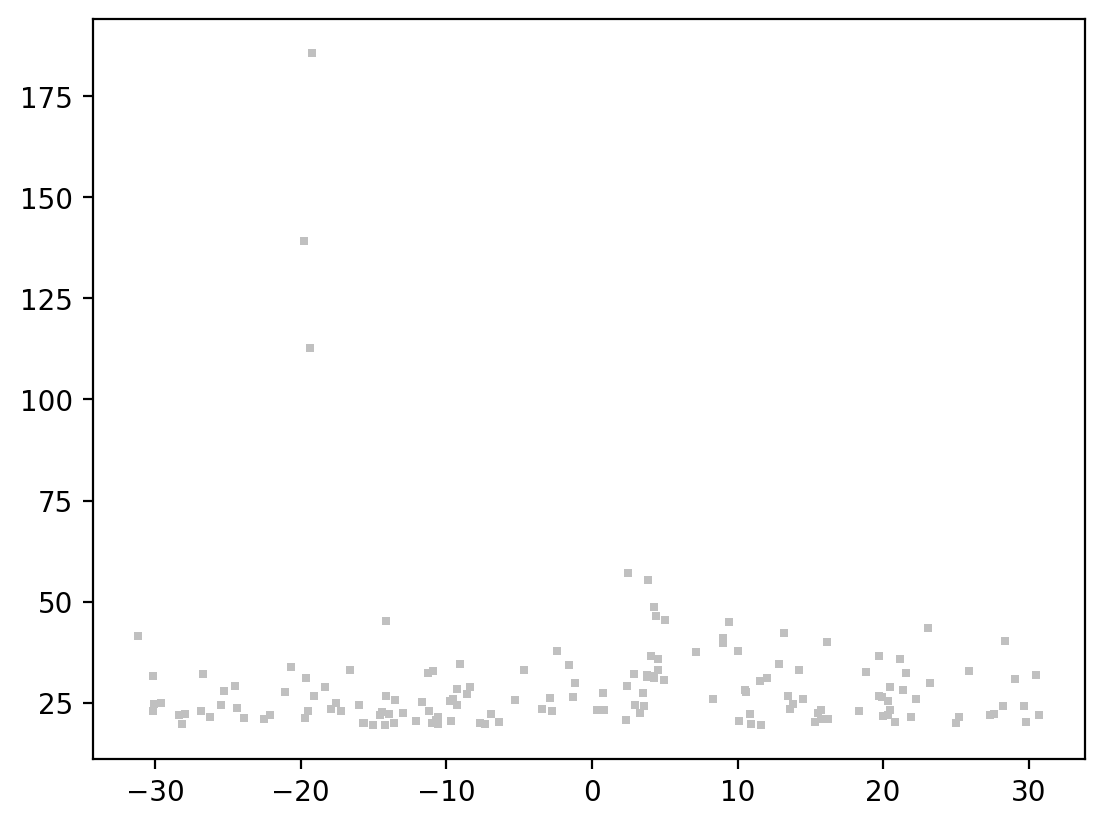

In [6]:
graph = load_graph("built_graphs/rebalanced/graph_0.npz")

gcn = GCN().to("cpu")
model = "trained_models/epoch1.pt"
gcn.load_state_dict(torch.load(model, map_location=torch.device("cpu")))
gcn.eval()

x, edge_index = graph.x.float(), graph.edge_index
y = graph.y.float()
print(edge_index.dtype)  # == torch.long
print(edge_index.dim())  # == 2
print(edge_index.size(0))  # == 2

row, col = edge_index
row, col = torch.cat([row, col], dim=0), torch.cat([col, row], dim=0)
edge_index = torch.stack([row, col], dim=0)
# y = torch.cat([y,y])

print(x.shape, edge_index.shape, y.shape)

data = Data(x=x, edge_index=edge_index, y=y)
data.num_nodes = len(x)


output = gcn(data)
# print(output.detach().numpy().squeeze(1))
loss = F.binary_cross_entropy(output.detach().squeeze(1), data.y)

print(loss.item())
draw_graph_rz(
    x.detach().numpy(),
    edge_index.detach().numpy(),
    y.detach().numpy(),
    output.detach().numpy().squeeze(1),
    cut=0.050,
    savefig=True,
    filename="confusion_matrix_graph.pdf",
)

In [10]:
for i in tqdm(range(800, 1000)):
    graph = load_graph("built_graphs/rebalanced/graph_" + str(i) + ".npz")

    gcn = GCN().to("cpu")
    model = "trained_models/epoch1.pt"
    gcn.load_state_dict(torch.load(model, map_location=torch.device("cpu")))
    gcn.eval()

    x, edge_index = graph.x.float(), graph.edge_index
    y = graph.y.float()
    # print(edge_index.dtype)# == torch.long
    # print(edge_index.dim())# == 2
    # print(edge_index.size(0))# == 2

    row, col = edge_index
    row, col = torch.cat([row, col], dim=0), torch.cat([col, row], dim=0)
    edge_index = torch.stack([row, col], dim=0)
    # y = torch.cat([y,y])

    # print(x.shape, edge_index.shape, y.shape)

    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_nodes = len(x)

    output = gcn(data)

    TP = x[np.intersect1d(np.where(y == 1), np.where(output > 0.5))]
    TN = x[np.intersect1d(np.where(y == 0), np.where(output < 0.5))]
    FP = x[np.intersect1d(np.where(y == 0), np.where(output > 0.5))]
    FN = x[np.intersect1d(np.where(y == 1), np.where(output < 0.5))]
    T = x[np.where(y == 1)]
    F = x[np.where(y == 0)]

    if i == 800:
        TP_tot = TP
        TN_tot = TN
        FP_tot = FP
        FN_tot = FN
        T_tot = T
        F_tot = F
    else:
        TP_tot = torch.cat((TP_tot, TP))
        TN_tot = torch.cat((TN_tot, TN))
        FP_tot = torch.cat((FP_tot, FP))
        FN_tot = torch.cat((FN_tot, FN))
        T_tot = torch.cat((T_tot, T))
        F_tot = torch.cat((F_tot, F))

100%|██████████| 200/200 [00:06<00:00, 32.95it/s]


Text(0.5, 0, '$p_T$')

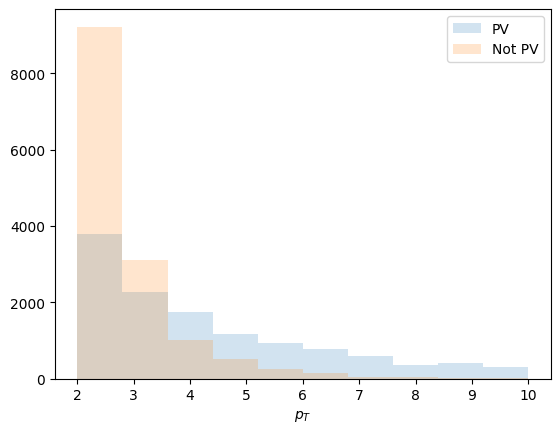

In [14]:
plt.hist(
    T_tot[:, 0].cpu().detach().numpy()[:15702], alpha=0.2, label="PV", range=(2, 10)
)
plt.hist(
    F_tot[:, 0].cpu().detach().numpy()[:15702], alpha=0.2, label="Not PV", range=(2, 10)
)
plt.legend()
plt.xlabel("$p_T$")

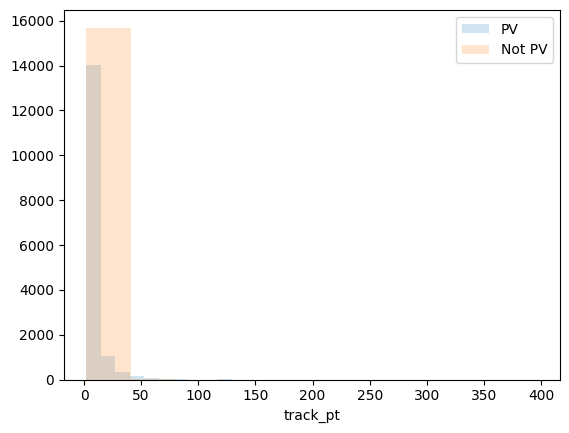

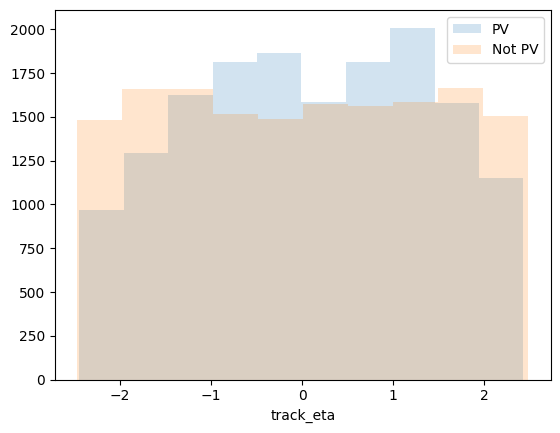

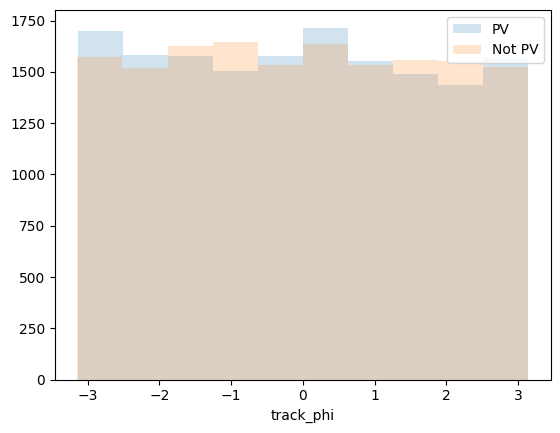

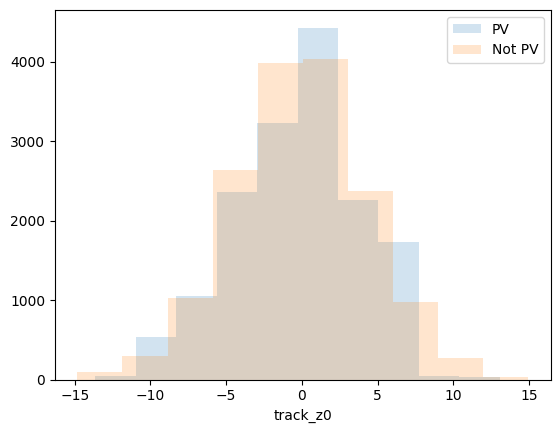

In [11]:
features = ["track_pt", "track_eta", "track_phi", "track_z0"]
for i in range(4):
    plt.hist(T_tot[:, i].cpu().detach().numpy()[:15702], alpha=0.2, label="PV")
    plt.hist(F_tot[:, i].cpu().detach().numpy()[:15702], alpha=0.2, label="Not PV")
    plt.legend()
    plt.xlabel(features[i])
    plt.show()

In [12]:
from sklearn.model_selection import train_test_split


ys = np.concatenate([np.ones(len(T_tot)), np.zeros(len(F_tot))])
xs = torch.cat((T_tot, F_tot)).cpu().detach().numpy()

x_train, x_test, y_train, y_test = train_test_split(
    xs, ys, random_state=32, test_size=0.3
)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)

rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500)

In [12]:
from sklearn.metrics import accuracy_score

y_test_pred = rf.predict(x_test)
y_train_pred = rf.predict(x_train)


accuracy_score(y_test, y_test_pred)
accuracy_score(y_train, y_train_pred)

NameError: name 'x_test' is not defined

In [13]:
len(y_test_pred)

NameError: name 'y_test_pred' is not defined

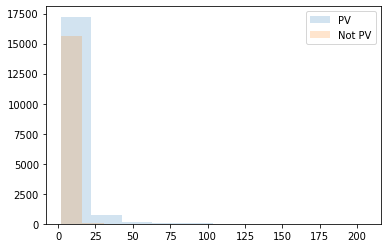

In [142]:
i = 0 
plt.hist(T_tot[:, i].cpu().detach().numpy(), alpha =0.2,  label='PV')
plt.hist(F_tot[:, i].cpu().detach().numpy(), alpha =0.2,  label='Not PV')
plt.legend()
plt.xlabel = features[i]
plt

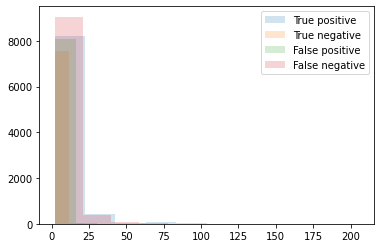

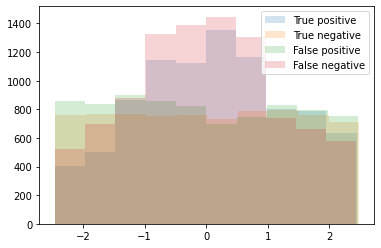

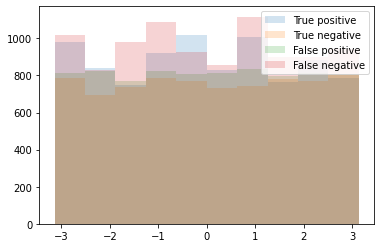

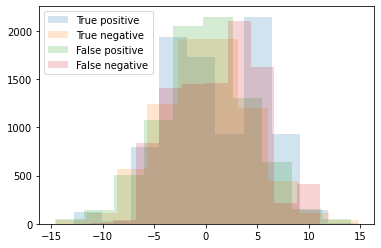

In [138]:
features = ['track_pt', 'track_eta', 'track_phi', 'track_z0']
for i in range(4): 
    plt.hist(TP_tot[:, i].cpu().detach().numpy(), alpha =0.2,  label='True positive')
    plt.hist(TN_tot[:, i].cpu().detach().numpy(), alpha =0.2,  label='True negative')
    plt.hist(FP_tot[:, i].cpu().detach().numpy(), alpha =0.2,  label='False positive')
    plt.hist(FN_tot[:, i].cpu().detach().numpy(), alpha =0.2,  label='False negative')
    plt.legend()
    plt.xlabel = features[i]
    plt.show() 

In [136]:
features[0]

'track_pt'

In [93]:
torch.cat((t,t))

tensor([[[ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 7.1076,  0.2018, -0.2157, -5.8008],
         [ 2.1846,  0.1266, -0.3046, -5.8008],
         ...,
         [ 3.5300, -1.6659, -0.7771, -0.2930],
         [ 2.4820, -2.1433, -0.7232, -6.9727],
         [ 2.5180,  2.3047, -0.5775, -4.1016]],

        [[ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         ...,
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250]],

        [[ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 7.1076,  0.2018, -0.2157, -5.8008],
         [ 2.1846,  0.1266, -0.3046, -5.8008],
         ...,
         [ 3.5300, -1.6659, -0.7771, -0.2930],
         [ 2.4820, -2.1433, -0.7232, -6.9727],
         [ 2.5180,  2.3047, -0.5775, -4.1016]],

        [[ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5

In [100]:
x[np.intersect1d(np.where(y==1), np.where(output > 0.5))]

tensor([[ 5.6759e+00,  2.7767e-01, -2.9672e-01, -5.6250e+00],
        [ 7.1076e+00,  2.0175e-01, -2.1566e-01, -5.8008e+00],
        [ 2.1846e+00,  1.2661e-01, -3.0461e-01, -5.8008e+00],
        [ 1.7539e+01,  2.0367e-01, -2.3263e-01, -5.6836e+00],
        [ 2.5463e+01,  2.2086e-01, -1.9960e-01, -5.8008e+00],
        [ 1.2850e+01,  2.0367e-01, -1.9988e-01, -5.6836e+00],
        [ 3.8204e+00,  1.4597e-01, -7.2756e-02, -5.6836e+00],
        [ 5.3763e+00,  2.6071e-01,  3.3113e-02, -5.7422e+00],
        [ 5.1351e+00,  1.7296e-01,  1.4797e-01, -5.6250e+00],
        [ 4.2374e+01,  2.3608e-01, -2.1700e-01, -5.8594e+00],
        [ 7.8515e+00,  8.3363e-01,  2.3854e+00, -5.5078e+00],
        [ 8.5664e+00,  8.2934e-01,  2.3678e+00, -5.5078e+00],
        [ 2.3081e+00,  2.1046e+00,  2.3858e+00, -6.0352e+00],
        [ 1.2213e+01,  9.2086e-01,  2.4856e+00, -5.6836e+00],
        [ 2.1641e+01,  9.3156e-01,  2.4810e+00, -5.9180e+00],
        [ 1.3656e+01,  9.1818e-01,  2.4656e+00, -5.6250e+00],
        

In [97]:
np.where((y==1)& (output > 0.5))[0]

array([  0,   0,   0, ..., 411, 411, 411])

In [110]:
tmp = torch.empty(1,1,4)

In [111]:
torch.cat((tmp, t))

RuntimeError: Sizes of tensors must match except in dimension 0. Got 1 and 327 in dimension 1 (The offending index is 1)

In [109]:
t

tensor([[[ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 7.1076,  0.2018, -0.2157, -5.8008],
         [ 2.1846,  0.1266, -0.3046, -5.8008],
         ...,
         [ 3.5300, -1.6659, -0.7771, -0.2930],
         [ 2.4820, -2.1433, -0.7232, -6.9727],
         [ 2.5180,  2.3047, -0.5775, -4.1016]],

        [[ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         ...,
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250],
         [ 5.6759,  0.2777, -0.2967, -5.6250]]])

In [106]:
tmp

tensor([[2.1395e-34, 3.0781e-41, 2.1379e-34, 3.0781e-41]])